In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import jax_tqdm
import equinox
import optax

from flowjax.distributions import StandardNormal, Transformed
from flowjax.bijections import (
    Affine,
    Chain,
    Coupling,
    EmbedCondition,
    Permute,
    RationalQuadraticSpline,
    Scan,
    TriangularAffine,
)
from flowjax.wrappers import non_trainable, BijectionReparam

from shallow.jax.transforms import get_post
from shallow.jax.utils import get_partition

In [2]:
key = jax.random.PRNGKey(0)

In [3]:
dim = 3
cond_dim = 2
layers = 5

In [4]:
# first data dimension is unit uniform
# second is standard normal truncated > 0
# third is normal with variable mean and standard deviation

# conditional dimensions are the mean and standard deviation of the normal above

def generate_data(key, n):
    key, _key = jax.random.split(key)
    x = jax.random.uniform(_key, (n,))
    
    key, _key = jax.random.split(key)
    y = jax.random.truncated_normal(_key, 0, jnp.inf, (n,))
    
    key, *keys = jax.random.split(key, 4)
    z = jax.random.normal(keys[0], (n,))
    loc = jax.random.uniform(keys[1], (n,)) * 10 - 5
    scale = jax.random.uniform(keys[2], (n,)) * 5
    z = z * scale + loc
    
    data = jnp.array([x, y, z]).T
    cond = jnp.array([loc, scale]).T

    return data, cond

In [5]:
key, _key = jax.random.split(key)
data, cond = generate_data(_key, 10_000)

In [6]:
data_bounds = [[0, 1], [0, None], None]
data_post = get_post(bounds = data_bounds, norms = data)
data_post = non_trainable(data_post)

cond_bounds = [None, [0, None]]
cond_post = get_post(bounds = cond_bounds, norms = cond)
cond_post = non_trainable(cond_post)

In [7]:
latent_data = jax.vmap(data_post.inverse)(data)
latent_cond = jax.vmap(cond_post.inverse)(cond)

In [8]:
# manually make a flow
# add affine layers in between
# initialize them so the inverse transforms the data to zero-mean unit-variance

# layers of the flow in the inverse direction: target -> base
bijections = []

for _ in range(layers):
    key, _key = jax.random.split(key)
    bijection = Coupling(
        key = _key,
        transformer = RationalQuadraticSpline(knots = 5, interval = 5.0),
        untransformed_dim = dim // 2,
        dim = dim,
        cond_dim = cond_dim,
        nn_width = 10,
        nn_depth = 1,
        nn_activation = jax.nn.relu,
    )
    bijections.append(bijection)
    latent_data = jax.vmap(bijection.inverse)(latent_data, latent_cond)

    key, _key = jax.random.split(key)
    bijection = Permute(jax.random.permutation(_key, dim))
    bijections.append(bijection)
    latent_data = jax.vmap(bijection.inverse)(latent_data, latent_cond)

    mean = jnp.mean(latent_data, axis = 0)
    std = jnp.std(latent_data, axis = 0)
    bijection = Affine(loc = mean, scale = std)
    bijections.append(bijection)
    latent_data = jax.vmap(bijection.inverse)(latent_data, latent_cond)

In [9]:
# reverse the order to the forward direction: base -> target
bijections = bijections[::-1]

bijection = Chain(bijections)
bijection = Chain([bijection, data_post])

# this lets us input conditions from their original space directly
bijection = EmbedCondition(
    bijection = bijection,
    embedding_net = cond_post.inverse,
    raw_cond_shape = (cond_dim,),
)

base_dist = StandardNormal(shape = (dim,))
base_dist = non_trainable(base_dist)

flow_init = Transformed(base_dist, bijection)

(Array([-1.13686838e-17,  5.57776048e-17, -1.25410793e-16], dtype=float64),
 Array([1., 1., 1.], dtype=float64))

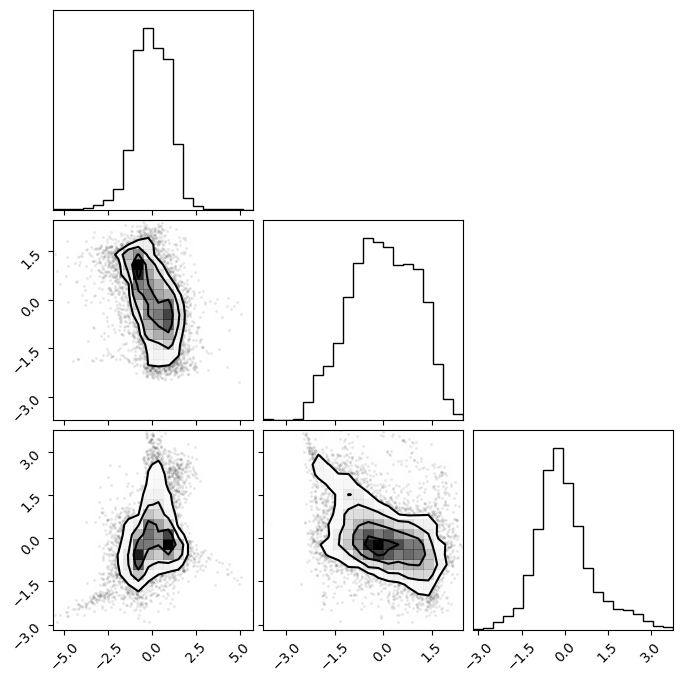

In [10]:
latent_data = jax.vmap(flow_init.bijection.inverse)(data, cond)
corner(np.array(latent_data))
latent_data.mean(axis = 0), latent_data.std(axis = 0)

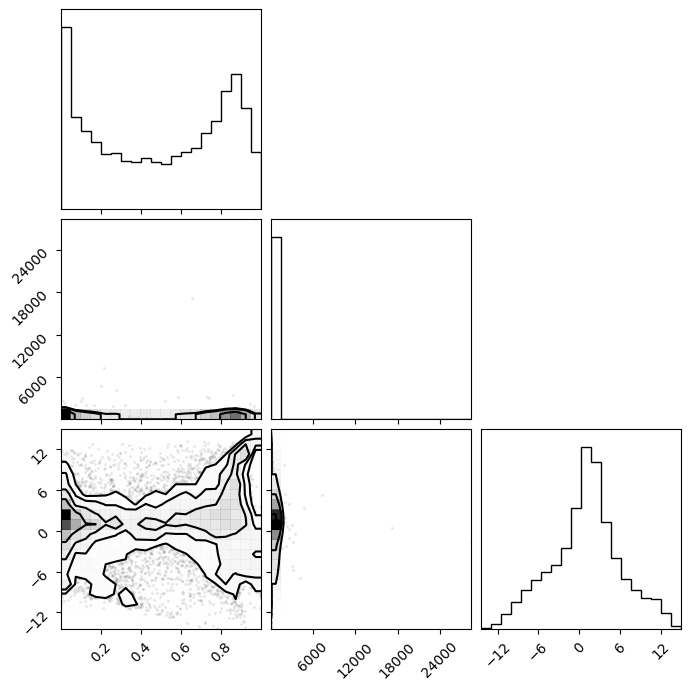

In [11]:
key, _key = jax.random.split(key)
x = flow_init.sample(
    key = _key,
    sample_shape = (10_000,), 
    condition = jnp.array([0, 1]),
)
# x = jax.vmap(data_post.inverse)(x)
corner(np.array(x));

In [12]:
params_init, static = get_partition(flow_init)

def loss_fn(params, data, cond):
    flow = equinox.combine(params, static)
    return -flow.log_prob(data, condition = cond).mean()

In [13]:
learning_rate = 1e-3
# learning_rate = optax.warmup_cosine_decay_schedule(
#     init_value = 1e-2,
#     peak_value = 1e-2,
#     warmup_steps = 1_000,
#     decay_steps = 2_000,
#     end_value = 1e-4,
#     exponent = 1.0,
# )

opt = optax.chain(
    # optax.add_noise(eta = 1.0, gamma = 0.55, seed = 0),
    # optax.clip_by_global_norm(max_norm = 1.0),
    optax.adamw(learning_rate = learning_rate, weight_decay = 0),
)

state_init = opt.init(params_init)

In [14]:
batch_size = 100
steps = 3_000

@jax_tqdm.scan_tqdm(steps, print_rate = 1)
@equinox.filter_jit
def step(carry, i):
    key, params, state = carry

    key, _key = jax.random.split(key)
    idxs = jax.random.choice(_key, data.shape[0], (batch_size,))
    train_loss, grad = equinox.filter_value_and_grad(loss_fn)(
        params, data[idxs], cond[idxs],
    )

    # generate random new batch of validation data
    key, _key = jax.random.split(key)
    valid_loss = loss_fn(params, *generate_data(_key, batch_size))
    
    updates, state = opt.update(grad, state, params)
    params = equinox.apply_updates(params, updates)

    return (key, params, state), {'train': train_loss, 'valid': valid_loss}

In [15]:
(key, params, state), loss = jax.lax.scan(
    step, (key, params_init, state_init), jnp.arange(steps),
)
flow = equinox.combine(params, static)

  0%|          | 0/3000 [00:00<?, ?it/s]

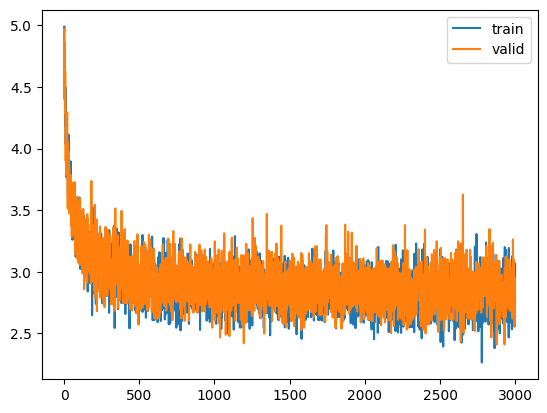

In [16]:
for k, v in loss.items():
    plt.plot(v, label = k)
plt.legend()

(Array([-0.04940071, -0.01475942, -0.04266605], dtype=float64),
 Array([1.01206781, 1.00144511, 0.99560629], dtype=float64))

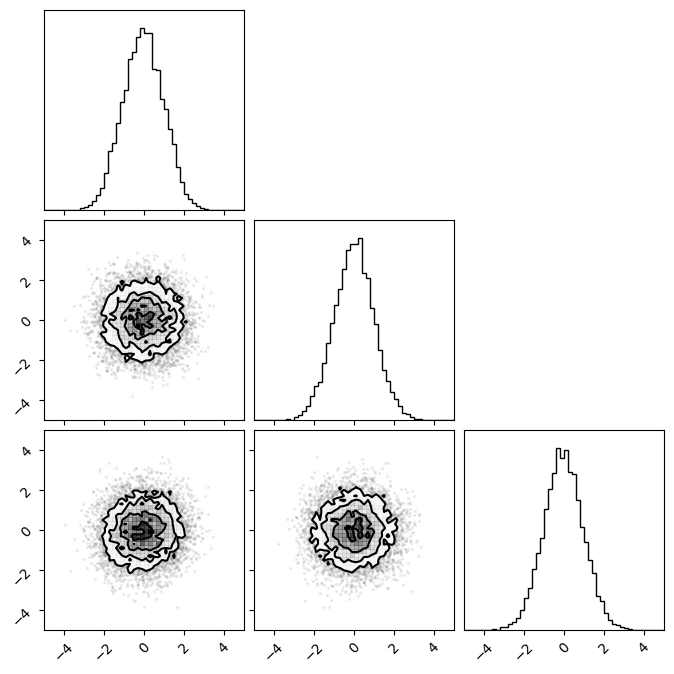

In [17]:
# transform our target samples through the inverse
# in the latent space these should be normal if the flow learns well

latent_data = jax.vmap(flow.bijection.inverse)(data, cond)
corner(np.array(latent_data), bins = 50, range = [[-5, 5]] * dim)

latent_data.mean(axis = 0), latent_data.std(axis = 0)

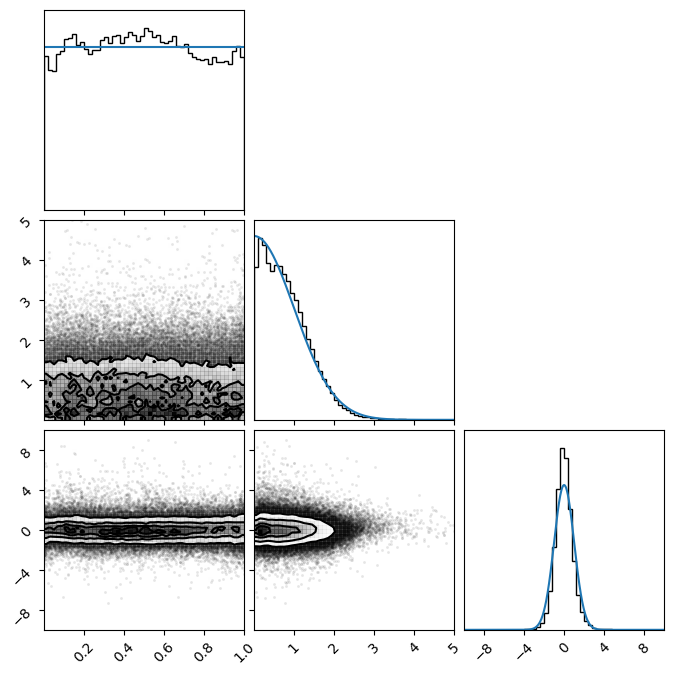

In [19]:
# sample new points from the flow
# check they match the target distribution

mean = 0
std = 1

key, _key = jax.random.split(key)
x = flow.sample(
    key = _key,
    sample_shape = (100_000,), 
    condition = jnp.array([mean, std]),
)

fig = corner(
    np.array(x),
    bins = 50,
    range = [[0, 1], [0, 5], [-10, 10]],
    hist_kwargs = dict(density = True),
)

axs = np.reshape(fig.axes, (dim, dim))

x = jnp.linspace(0, 1, 1_000)
y = jnp.ones_like(x)
axs[0, 0].plot(x, y)

x = jnp.linspace(0, 5, 1_000)
y = jax.scipy.stats.truncnorm.pdf(x, a = 0, b = jnp.inf)
axs[1, 1].plot(x, y)

x = jnp.linspace(-10, 10, 1_000)
y = jax.scipy.stats.norm.pdf(x, loc = mean, scale = std)
fig.axes[-1].plot(x, y)